# Cross - validation

In [1]:
import pandas as pd
from feature_engineering.engineering import *
from feature_engineering.processing import *
from joblib import load
import warnings
warnings.filterwarnings('ignore')
pipeline_processing = load('../feature_engineering/pipelines/processing_pipeline.joblib')
pipeline_engineering = load('../feature_engineering/pipelines/engineering_pipeline.joblib')

In [2]:
X_train = pd.read_csv('../data/orig_train.csv')

y_train = X_train['DEFAULT_FLAG']
X_train.drop(columns=['DEFAULT_FLAG'], inplace=True)


pipeline_processing.fit(X_train)
X_train = pipeline_processing.transform(X_train)
pipeline_engineering.fit(X_train)
X_train = pipeline_engineering.transform(X_train)

In [3]:
X_val = pd.read_csv('../data/orig_valid.csv')

y_val = X_val['DEFAULT_FLAG']
X_val.drop(columns=['DEFAULT_FLAG'], inplace=True)

X_val = pipeline_processing.transform(X_val)
X_val = pipeline_engineering.transform(X_val)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier  
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold

In [5]:
models = [RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, random_state=42),
          XGBClassifier(subsample=0.8, min_child_weight=1, max_depth=5, gamma=0.5, colsample_bytree=0.6),
          LogisticRegression(random_state=42),
          GradientBoostingClassifier(random_state=42),
          MLPClassifier(random_state=42),
          GaussianNB(),
          AdaBoostClassifier(random_state=42),
          DecisionTreeClassifier(random_state=42),
          SVC(probability=True, random_state=42)
          ]


In [6]:
def cross_validate_calculate_scores(models, X, y, scoring):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for model in models:
        model_name = model.__class__.__name__
        for score, score_name in scoring.items():  
            scores_result = cross_val_score(model, X, y, cv=skf, scoring=score)
            results[(model_name, score_name)] = scores_result
        
    return results

In [7]:
scoring = {'roc_auc': 'roc_auc', 'f1': 'f1', 'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}
cross_val_scores = cross_validate_calculate_scores(models, X_train, y_train, scoring)

In [8]:
cross_val_scores 

{('RandomForestClassifier',
  'roc_auc'): array([0.91631897, 0.88498389, 0.87881368, 0.874182  , 0.87393015]),
 ('RandomForestClassifier',
  'f1'): array([0.22110553, 0.26923077, 0.24365482, 0.21649485, 0.25742574]),
 ('RandomForestClassifier',
  'accuracy'): array([0.9486755 , 0.94966887, 0.95064591, 0.9496522 , 0.95031467]),
 ('RandomForestClassifier',
  'precision'): array([0.84615385, 0.8       , 0.96      , 1.        , 0.89655172]),
 ('RandomForestClassifier',
  'recall'): array([0.12716763, 0.16184971, 0.13953488, 0.12138728, 0.15028902]),
 ('XGBClassifier',
  'roc_auc'): array([0.89133679, 0.8738252 , 0.86033953, 0.85336686, 0.85587317]),
 ('XGBClassifier',
  'f1'): array([0.3231441 , 0.29955947, 0.28959276, 0.30275229, 0.30222222]),
 ('XGBClassifier',
  'accuracy'): array([0.9486755 , 0.94735099, 0.94799603, 0.9496522 , 0.94799603]),
 ('XGBClassifier',
  'precision'): array([0.66071429, 0.62962963, 0.65306122, 0.73333333, 0.65384615]),
 ('XGBClassifier',
  'recall'): array([0.2

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cross_validate_scores(cross_val_scores, scoring):
    sns.set_palette(sns.color_palette('hls', 8))
    num_metrics = len(scoring)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 3 * num_metrics), sharex=True, sharey=False)

    scores_by_metric = {}
    for (model_name, metric_name), scores in cross_val_scores.items():
        if metric_name not in scores_by_metric:
            scores_by_metric[metric_name] = {}
        scores_by_metric[metric_name][model_name] = scores

    for i, (metric_name, scores) in enumerate(scores_by_metric.items()):
        min_score = min(min(scores) for scores in scores_by_metric[metric_name].values())
        max_score = max(max(scores) for scores in scores_by_metric[metric_name].values())
        sns.boxplot(data=list(scores.values()), ax=axes[i])
        axes[i].set_ylim(min_score - 0.01, max_score + 0.01)
        axes[i].set_xticklabels(scores.keys(), rotation=45, fontsize=10)
        axes[i].set_title(metric_name)
        axes[i].set_ylabel('Score')
    fig.suptitle('Cross-validation scores')
    plt.tight_layout()
    plt.show()
    return scores_by_metric


### Training data

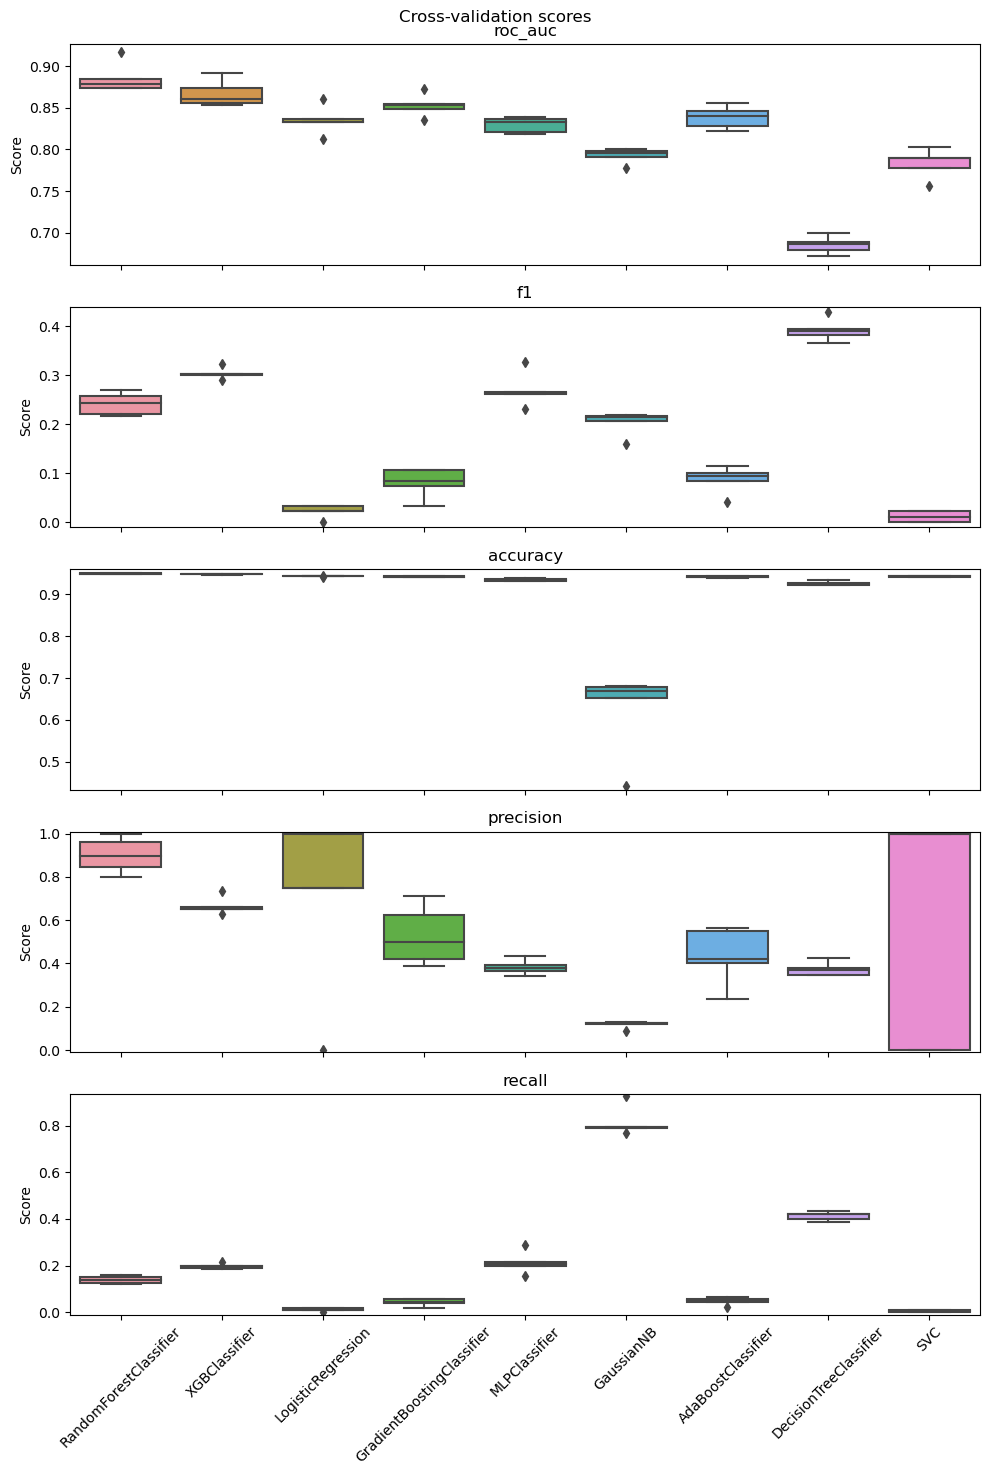

In [40]:
scores_by_metric = plot_cross_validate_scores(cross_val_scores, scoring)

In [11]:
print(scores_by_metric)

{'roc_auc': {'RandomForestClassifier': array([0.91631897, 0.88498389, 0.87881368, 0.874182  , 0.87393015]), 'XGBClassifier': array([0.89133679, 0.8738252 , 0.86033953, 0.85336686, 0.85587317]), 'LogisticRegression': array([0.86092652, 0.83288159, 0.83667631, 0.83237807, 0.81296942]), 'GradientBoostingClassifier': array([0.87240093, 0.85356962, 0.85461747, 0.8487635 , 0.8346965 ]), 'MLPClassifier': array([0.83661739, 0.83903754, 0.82102744, 0.83316408, 0.81786424]), 'GaussianNB': array([0.79548495, 0.79140602, 0.80040393, 0.79846778, 0.77742415]), 'AdaBoostClassifier': array([0.85530962, 0.84623404, 0.84012138, 0.82754926, 0.82254884]), 'DecisionTreeClassifier': array([0.68920535, 0.67151306, 0.70010966, 0.67974523, 0.68691379]), 'SVC': array([0.80253629, 0.75621839, 0.77807525, 0.78945605, 0.78911889])}, 'f1': {'RandomForestClassifier': array([0.22110553, 0.26923077, 0.24365482, 0.21649485, 0.25742574]), 'XGBClassifier': array([0.3231441 , 0.29955947, 0.28959276, 0.30275229, 0.30222222

In [45]:
from tabulate import tabulate

def print_scores(scores_by_metric):
    table_data = [(model_name, metric_name, *scores, scores.mean()) for (model_name, metric_name), scores in cross_val_scores.items()]
    headers = ["Model", "Metric", "Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Mean"]
    print(tabulate(table_data, headers=headers))

In [46]:
print_scores(scores_by_metric)

Model                       Metric        Fold 1     Fold 2     Fold 3     Fold 4      Fold 5        Mean
--------------------------  ---------  ---------  ---------  ---------  ---------  ----------  ----------
RandomForestClassifier      roc_auc    0.916319   0.884984   0.878814   0.874182   0.87393     0.885646
RandomForestClassifier      f1         0.221106   0.269231   0.243655   0.216495   0.257426    0.241582
RandomForestClassifier      accuracy   0.948675   0.949669   0.950646   0.949652   0.950315    0.949791
RandomForestClassifier      precision  0.846154   0.8        0.96       1          0.896552    0.900541
RandomForestClassifier      recall     0.127168   0.16185    0.139535   0.121387   0.150289    0.140046
XGBClassifier               roc_auc    0.891337   0.873825   0.86034    0.853367   0.855873    0.866948
XGBClassifier               f1         0.323144   0.299559   0.289593   0.302752   0.302222    0.303454
XGBClassifier               accuracy   0.948675   0.947351  

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_comparison(models, X, y):
    results = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
        gini_scores = 2 * scores - 1
        results.append([model_name] + list(gini_scores) + [gini_scores.mean()])

    headers = ['Model'] + [f'Fold {i+1}' for i in range(5)] + ['Mean']
    print('GINI Scores:')
    print(tabulate(results, headers=headers, tablefmt='simple'))

#### GINI 

In [36]:
cross_validate_comparison(models, X_train, y_train)

GINI Scores:
Model                         Fold 1    Fold 2    Fold 3    Fold 4    Fold 5      Mean
--------------------------  --------  --------  --------  --------  --------  --------
RandomForestClassifier      0.832638  0.769968  0.757627  0.748364  0.74786   0.771291
XGBClassifier               0.782674  0.74765   0.720679  0.706734  0.711746  0.733897
LogisticRegression          0.721853  0.665763  0.673353  0.664756  0.625939  0.670333
GradientBoostingClassifier  0.744802  0.707139  0.709235  0.697527  0.669393  0.705619
MLPClassifier               0.673235  0.678075  0.642055  0.666328  0.635728  0.659084
GaussianNB                  0.59097   0.582812  0.600808  0.596936  0.554848  0.585275
AdaBoostClassifier          0.710619  0.692468  0.680243  0.655099  0.645098  0.676705
DecisionTreeClassifier      0.378411  0.343026  0.400219  0.35949   0.373828  0.370995
SVC                         0.605073  0.512437  0.55615   0.578912  0.578238  0.566162


### Validation data

In [37]:
cross_val_scores_val_data = cross_validate_calculate_scores(models, X_val, y_val, scoring)

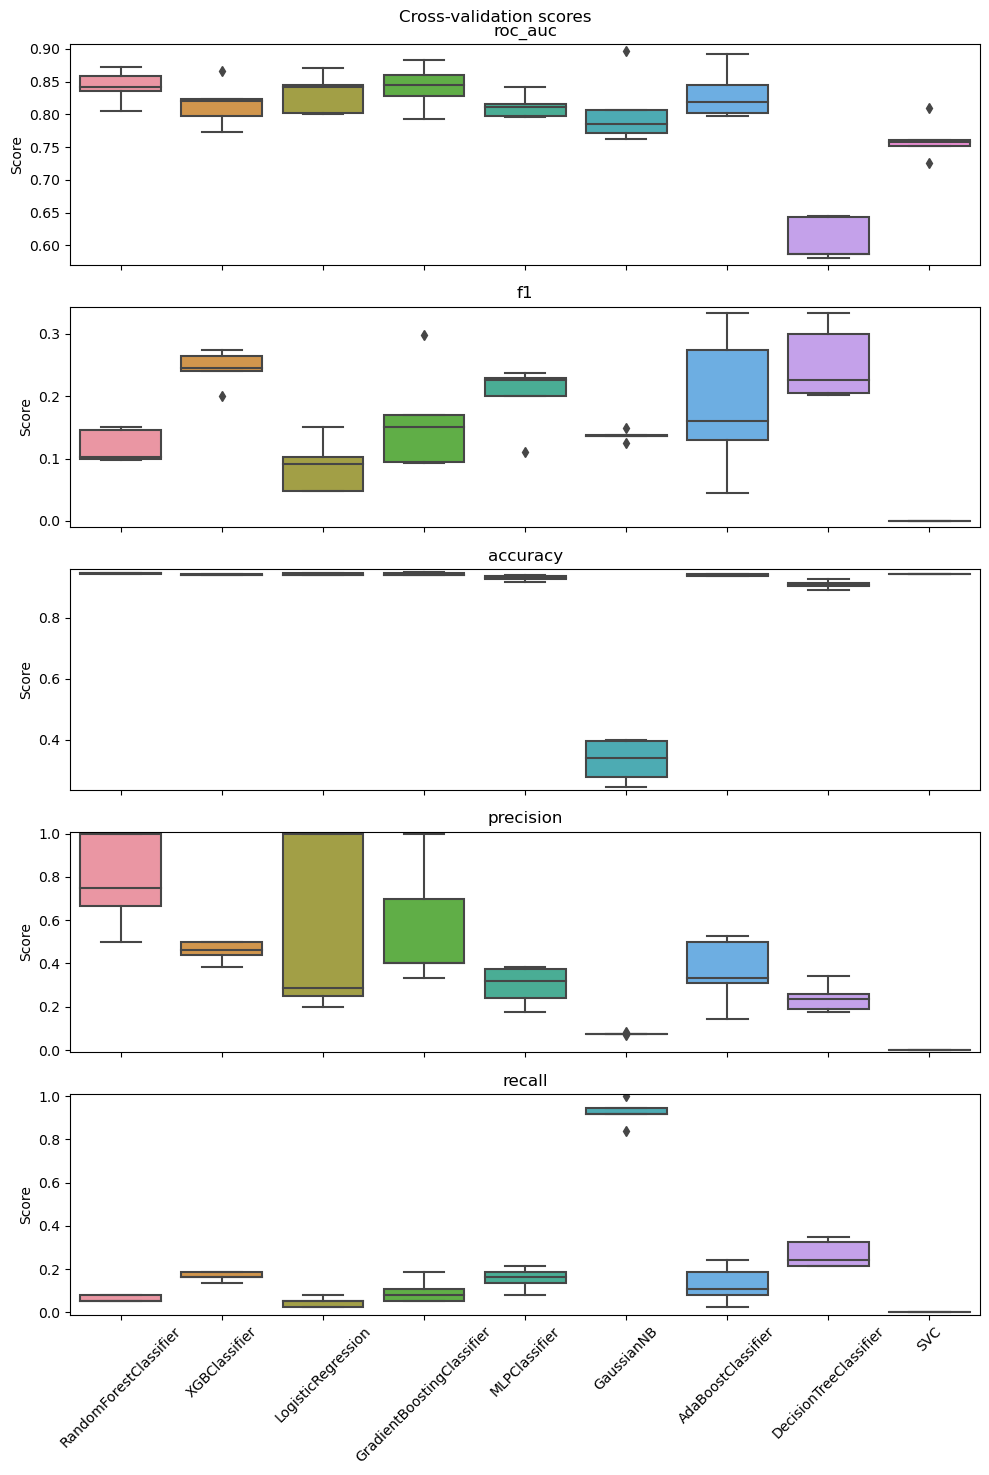

In [41]:
scores_by_metric_val_data = plot_cross_validate_scores(cross_val_scores_val_data, scoring)

In [47]:
print_scores(scores_by_metric_val_data)

Model                       Metric        Fold 1     Fold 2     Fold 3     Fold 4      Fold 5        Mean
--------------------------  ---------  ---------  ---------  ---------  ---------  ----------  ----------
RandomForestClassifier      roc_auc    0.916319   0.884984   0.878814   0.874182   0.87393     0.885646
RandomForestClassifier      f1         0.221106   0.269231   0.243655   0.216495   0.257426    0.241582
RandomForestClassifier      accuracy   0.948675   0.949669   0.950646   0.949652   0.950315    0.949791
RandomForestClassifier      precision  0.846154   0.8        0.96       1          0.896552    0.900541
RandomForestClassifier      recall     0.127168   0.16185    0.139535   0.121387   0.150289    0.140046
XGBClassifier               roc_auc    0.891337   0.873825   0.86034    0.853367   0.855873    0.866948
XGBClassifier               f1         0.323144   0.299559   0.289593   0.302752   0.302222    0.303454
XGBClassifier               accuracy   0.948675   0.947351  

#### GINI

In [42]:
cross_validate_comparison(models, X_val, y_val)

GINI Scores:
Model                         Fold 1    Fold 2    Fold 3    Fold 4    Fold 5      Mean
--------------------------  --------  --------  --------  --------  --------  --------
RandomForestClassifier      0.744528  0.683429  0.66996   0.609437  0.716881  0.684847
XGBClassifier               0.731059  0.646788  0.546389  0.593443  0.641825  0.631901
LogisticRegression          0.740275  0.683739  0.600266  0.60319   0.689411  0.663376
GradientBoostingClassifier  0.766859  0.719052  0.656978  0.587151  0.688259  0.68366
MLPClassifier               0.683208  0.622862  0.590696  0.594772  0.632787  0.624865
GaussianNB                  0.794462  0.612096  0.569384  0.525919  0.541648  0.608702
AdaBoostClassifier          0.785202  0.688214  0.602924  0.594506  0.637705  0.66171
DecisionTreeClassifier      0.290696  0.160479  0.173593  0.174391  0.286619  0.217156
SVC                         0.617811  0.503943  0.451661  0.522198  0.516172  0.522357
